# Playlist Data Set Analysis Exercise

The question is **“What makes a playlist successful?”**

In [99]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

sns.set_style('dark')
mpl.rcParams['figure.figsize'] = 1.2*np.array([8.0, 6.0])
mpl.rcParams['font.size'] = 1.2*12

In [100]:
df = pd.read_csv('playlist_summary_external.txt', sep="\t")

**Dropping unwanted columns**

* 'playlist_uri', 'owner': annonimized names not informative
* 'owner_country': All the owner_country are US
* 'streams': short streams don't speak of success

In [101]:
df.drop(['playlist_uri', 'owner', 'owner_country', 'streams'], axis=1, inplace=True)

In [102]:
len(df)

403366

In [103]:
df['n_tracks_log'] = np.log(df.n_tracks)

df['single_artist'] = df.n_artists == 1
df['n_artists_log'] = np.log(df.n_artists)

df['single_album'] = df.n_albums == 1
df['n_albums_log'] = np.log(df.n_albums)

df['monthly_stream30s_log'] = np.log(df.monthly_stream30s)

## Why I log-transform

I would not show this at the presentation

/home/federico/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/federico/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/federico/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/federico/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/federico/anaconda3/lib

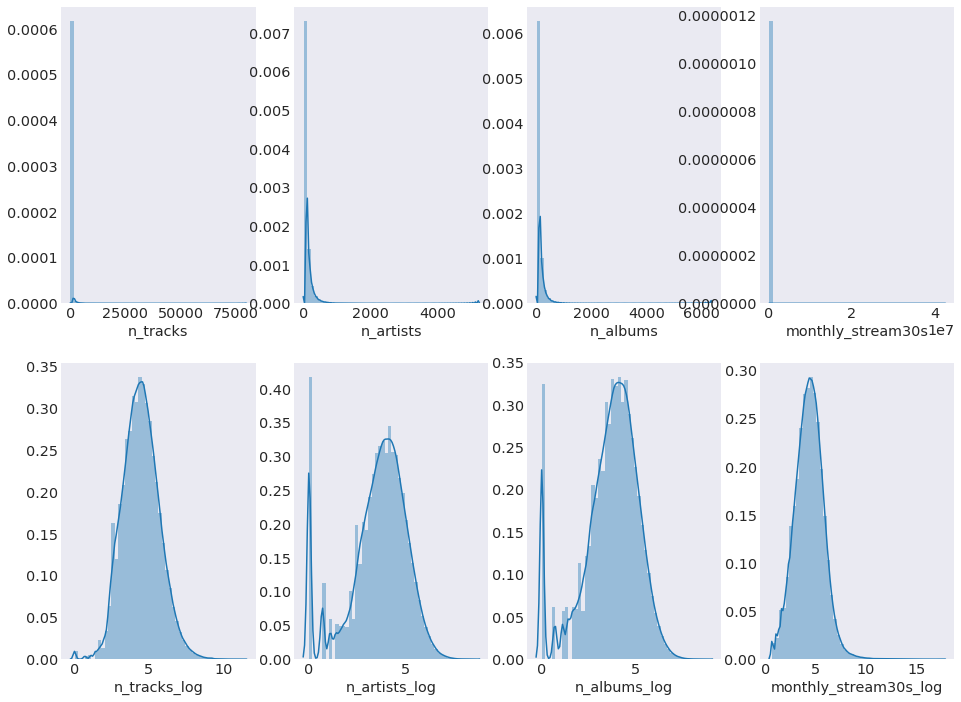

In [122]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=2*np.array([8.0, 6.0]))
sns.distplot(df.n_tracks, ax=axs[0, 0])
sns.distplot(df.n_artists, ax=axs[0, 1])
sns.distplot(df.n_albums, ax=axs[0, 2])
sns.distplot(df.monthly_stream30s, ax=axs[0, 3])

sns.distplot(df.n_tracks_log, ax=axs[1, 0])
sns.distplot(df.n_artists_log, ax=axs[1, 1])
sns.distplot(df.n_albums_log, ax=axs[1, 2])
sns.distplot(df.monthly_stream30s_log, ax=axs[1, 3])

plt.show()

## Dummy variables for the first genre and mood

In [106]:
# We keep only the first mood
mood = pd.get_dummies(df.mood_1, 'mood')
mood.drop('mood_-', axis=1, inplace=True)
df = pd.concat([df, mood], axis=1)

In [108]:
# We keep only the first genre
genre = pd.get_dummies(df.genre_1, 'genre')
genre.drop('genre_-', axis=1, inplace=True)
df = pd.concat([df, genre], axis=1)

## Metric: monthly streams over 30s

### Monthly streams vs N of tracks

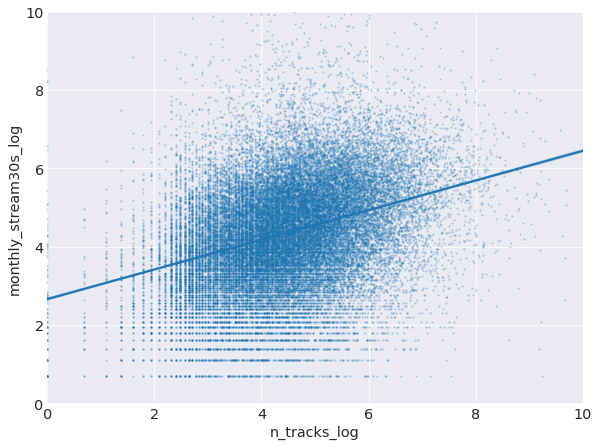

In [110]:
sns.regplot(df.n_tracks_log[:int(0.1*len(df))], df.monthly_stream30s_log[:int(0.1*len(df))], scatter_kws={'alpha': 0.2, 's': 2})
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.grid()
plt.show()

### Monthly streams vs N of artists

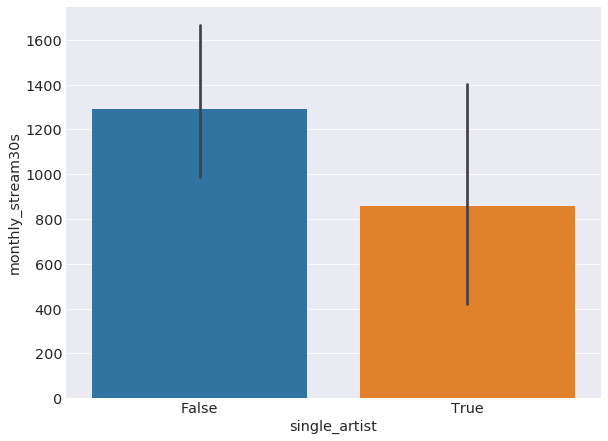

In [111]:
sns.barplot(x='single_artist', y='monthly_stream30s', data=df)
plt.grid(axis='y');

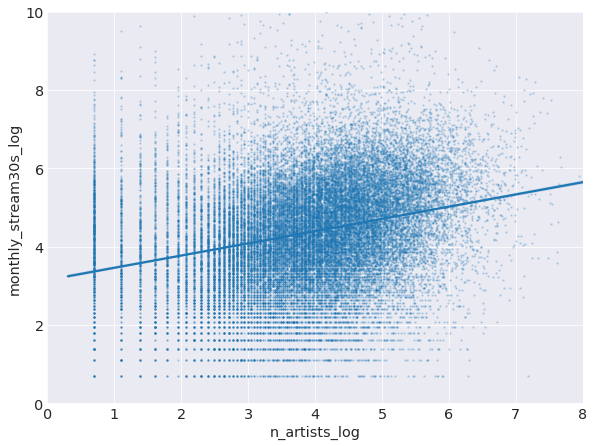

In [112]:
df_mult_artists = df[~df.single_artist]
sns.regplot(x='n_artists_log', y='monthly_stream30s_log', data=df_mult_artists[:int(0.1*len(df_mult_artists))], 
            scatter_kws={'alpha': 0.2, 's': 2})
plt.xlim(0, 8)
plt.ylim(0, 10)
plt.grid();

### Monthly streams vs N of albums

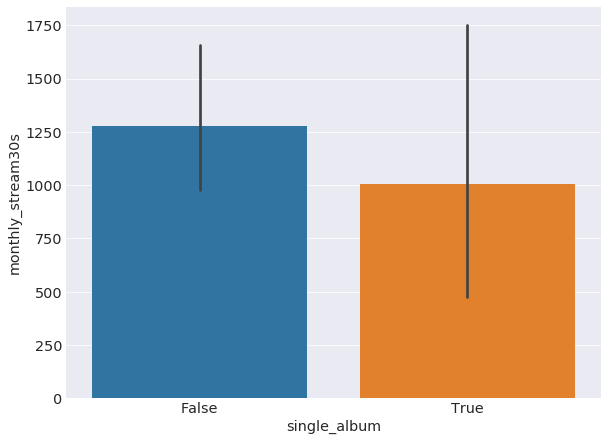

In [113]:
sns.barplot(x='single_album', y='monthly_stream30s', data=df)
plt.grid(axis='y');

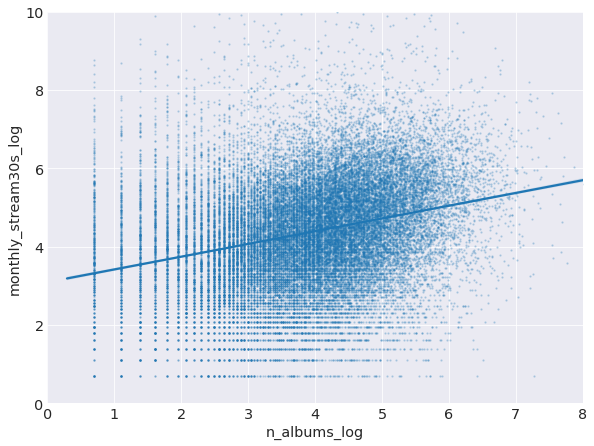

In [114]:
df_mult_albums = df[~df.single_album]
sns.regplot(x='n_albums_log', y='monthly_stream30s_log', data=df_mult_albums[:int(0.1*len(df_mult_albums))], 
            scatter_kws={'alpha': 0.2, 's': 2})
plt.xlim(0, 8)
plt.ylim(0, 10)
plt.grid();

### Monthly streams vs genre

In [115]:
counts = df.genre_1.value_counts(normalize=True)
df_genre = df.loc[df.genre_1.isin(counts[counts > 0.01].index), :]

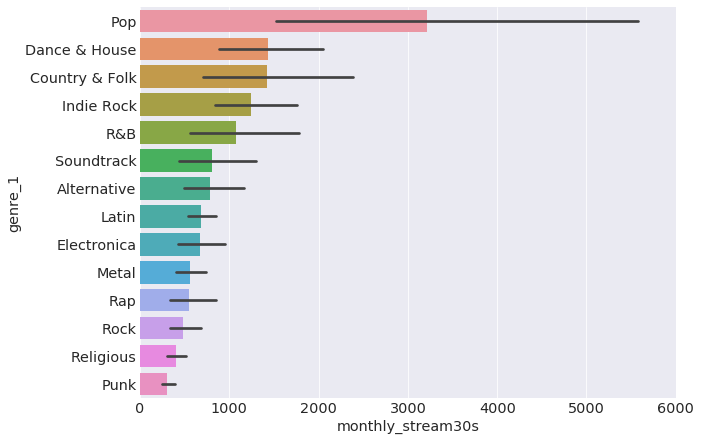

In [116]:
sns.barplot(y='genre_1', x='monthly_stream30s', data=df_genre, order=df_genre.groupby('genre_1').monthly_stream30s.mean().sort_values(ascending=False).index)
plt.xlim(0, 6000)
plt.grid(axis='x');

### Monthly streams vs mood

In [117]:
counts_mood = df.mood_1.value_counts(normalize=True)
df_mood = df.loc[df.mood_1.isin(counts_mood[counts_mood > 0.01].index), :]

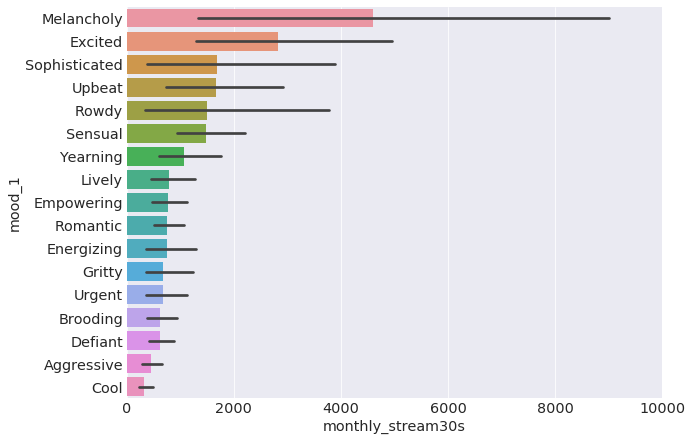

In [118]:
sns.barplot(y='mood_1', x='monthly_stream30s', data=df_mood, order=df_mood.groupby('mood_1').monthly_stream30s.mean().sort_values(ascending=False).index)
plt.xlim(0, 10000)
plt.grid(axis='x');

### Model

In [119]:
X = df[['n_tracks_log', 'n_artists_log', 'n_albums_log'] + list(mood.columns) + list(genre.columns)]
y = np.log(df.monthly_stream30s)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [121]:
param_grid = {"max_features": [5, 10, 15],
              "min_samples_leaf": [10, 20, 30]}

model = RandomForestRegressor(random_state=0, n_estimators=100)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 14.2min finished


0.1301141317870839
{'max_features': 10, 'min_samples_leaf': 20}


In [123]:
regressor = RandomForestRegressor(random_state=0, n_estimators=100, max_features=10, min_samples_leaf=20)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [124]:
regressor.score(X_test, y_test)

0.12874045015364965

Nice, no overfitting

In [125]:
fig = plt.figure(figsize=(15, 10))
regressor.fit(X, y)

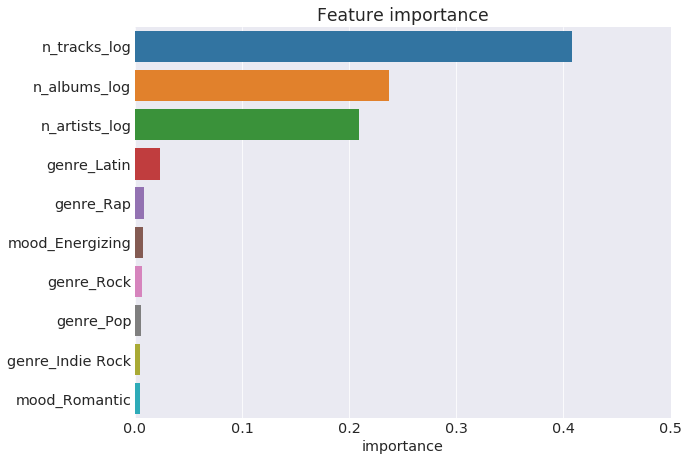

In [130]:
feature_importances = pd.DataFrame(regressor.feature_importances_, index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
#feature_importances.index = feature_importances.index.str.replace('_', '\n')
sns.barplot(feature_importances.importance[:10], feature_importances.index[:10])
plt.title('Feature importance')
plt.xlim(0, 0.5)
plt.grid(axis='x')
plt.show()

**CONCERN**: this result does not reflect what I saw before. 

### Summary

Dataset is super noisy but overall we can say that a good playlist is

* Varied in terms of artists and albums
* It has many songs --> **this is strange, I expected an "optimum" number of songs**
* Pop 
* Melancholy, excited moods

## What more to do

* Other measure of success?